# Model 1: Multivariate-3-RNN

## RNN

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras import optimizers

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [5]:
plt.style.use('ggplot')

### Hàm callback

In [6]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-szc-rnn.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"SZC_stock_data.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [8]:
print(df.head)

<bound method NDFrame.head of              open   high    low  close   volume
time                                           
2019-01-15   8.97   8.97   6.58   6.58   109570
2019-01-16   6.58   7.03   6.58   7.03    27940
2019-01-17   7.51   7.51   7.51   7.51   119080
2019-01-18   7.84   7.89   7.51   7.51    50480
2019-01-21   7.51   7.51   7.12   7.12    13560
...           ...    ...    ...    ...      ...
2024-03-14  44.25  45.32  43.33  43.86  2243970
2024-03-15  43.67  43.86  42.94  43.86  2592889
2024-03-18  43.81  43.81  40.79  41.13  3896580
2024-03-19  41.42  41.62  40.79  41.38  1409570
2024-03-20  41.33  42.40  40.99  42.06  1099459

[1293 rows x 5 columns]>


In [9]:
print(df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


### Tiền xử lí dữ liệu

In [10]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [11]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.997768
high      0.999022
low       0.998935
close     1.000000
volume    0.444012
Name: close, dtype: float64

In [12]:
#  Tính toán các thống kê mô tả như trung bình (mean), độ lệch chuẩn (std), min, max, phần trăm phân vị (25%, 50%, 75%).
print(df.describe().volume) # Giúp kiểm tra phân bố của Volume, phát hiện các giá trị bất thường (outliers).

count    1.293000e+03
mean     9.618657e+05
std      7.256608e+05
min      2.400000e+02
25%      4.538290e+05
50%      8.436720e+05
75%      1.285800e+06
max      4.346420e+06
Name: volume, dtype: float64


<Axes: >

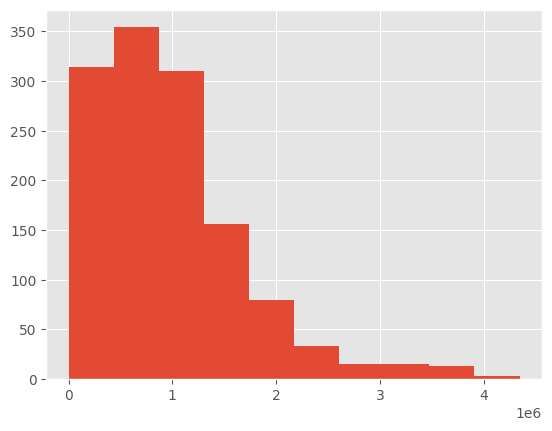

In [13]:
# Vẽ biểu đồ tần suất của Volume
df['volume'].hist(bins=10)

**Phân tích phân bố dữ liệu Volume bằng Histogram**  

🔹 `.hist(bins=10)`  
- Vẽ **biểu đồ histogram** của cột `Volume` với **10 bins (nhóm dữ liệu)**.  
- Giúp trực quan hóa **phân bố dữ liệu**, phát hiện sự **lệch** (skewness) và **giá trị ngoại lai** (outliers).  

**Ý nghĩa của biểu đồ histogram**  

- **Nếu phân bố lệch phải (right-skewed)** → Dữ liệu có nhiều giá trị nhỏ, một số giá trị rất lớn.  
- **Nếu phân bố lệch trái (left-skewed)** → Dữ liệu có nhiều giá trị lớn, một số giá trị rất nhỏ.  
- **Nếu có outliers (điểm nằm xa tập trung chính)** → Có thể cần xử lý như **loại bỏ** hoặc **chuẩn hóa dữ liệu**.  

**Cách xử lý dữ liệu lệch/skewed**  

✅ **Log Transformation** → Dùng `np.log1p(Volume)` để giảm độ lệch.  
✅ **Scaling** → Dùng `MinMaxScaler()` hoặc `StandardScaler()` để chuẩn hóa.  
✅ **Xử lý outliers** → Loại bỏ hoặc thay thế bằng **giá trị trung bình/median**.  


In [14]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [15]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2019-01-15  8.97  8.97  6.58   6.58  109570    NaN    NaN    NaN  6.580000   
2019-01-16  6.58  7.03  6.58   7.03   27940    NaN    NaN    NaN  6.649231   
2019-01-17  7.51  7.51  7.51   7.51  119080    NaN    NaN    NaN  6.781657   
2019-01-18  7.84  7.89  7.51   7.51   50480    NaN    NaN    NaN  6.893710   
2019-01-21  7.51  7.51  7.12   7.12   13560    NaN    NaN    NaN  6.928524   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2019-01-15  6.580000  0.000000  NaN  NaN NaN NaN  
2019-01-16  6.613333  0.035897  NaN  NaN NaN NaN  
2019-01-17  6.679753  0.101904  NaN  NaN NaN NaN  
2019-01-18  6.741253  0.152457  NaN  NaN NaN NaN  
2019-01-21  6.769308  0.159215  NaN  NaN NaN NaN  


(1293, 15)

## Train model / Hàm **fit_model_2()**

In [16]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate= lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    for layer in model.layers:
        if isinstance(layer, SimpleRNN):
            layer.reset_states() #Đảm bảo mỗi lần huấn luyện không bị ảnh hưởng bởi trạng thái cũ của LSTM.
    return model, history.history['loss'], history.history['val_loss']

###  Bước 1: Đặt Seed để đảm bảo tính tái lập

Giúp đảm bảo mỗi lần chạy chương trình, các giá trị ngẫu nhiên được tạo ra giống nhau, tránh kết quả huấn luyện thay đổi giữa các lần chạy.

In [ ]:
"""
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)
"""

'\nnp.random.seed(1)\ntf.random.set_seed(2)\nrn.seed(3)\n'

### Bước 2: Chuẩn bị dữ liệu huấn luyện (train) và kiểm định (val)

In [ ]:
"""
X_train = []
Y_train = []
X_val = []
Y_val = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train, Y_train = np.array(X_train, Y_train)

for i in range(timesteps, val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val, Y_val = np.array(X_val, Y_val)  
"""

'\nX_train = []\nY_train = []\nX_val = []\nY_val = []\n\nfor i in range(timesteps, train.shape[0]):\n    X_train.append(train[i-timesteps:i])\n    Y_train.append(train[i][0])\nX_train, Y_train = np.array(X_train, Y_train)\n\nfor i in range(timesteps, val.shape[0]):\n    X_val.append(val[i-timesteps:i])\n    Y_val.append(val[i][0])\nX_val, Y_val = np.array(X_val, Y_val)  \n'

### Bước 3: Xây dựng mô hình RNN

In [ ]:
"""
# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
for i in range(len(hl)-1):
    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))
model.add(SimpleRNN(hl[-1], activation='relu'))
model.add(Dense(1))
"""

"\n# Xây dựng mô hình RNN\nmodel = Sequential()\nmodel.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))\nfor i in range(len(hl)-1):\n    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))\nmodel.add(SimpleRNN(hl[-1], activation='relu'))\nmodel.add(Dense(1))\n"

Thêm một lớp **SimpleRNN đầu tiên**:  
-   `X_train.shape[2]`: Số đặc trưng (features).
-   `input_shape = (X_train.shape[1], X_train.shape[2])`: Định dạng đầu vào (timesteps, số đặc trưng).
-   `activation = 'relu'`: Hàm kích hoạt giúp mô hình học phi tuyến tính.
-   `return_sequences = True`: Giữ lại toàn bộ chuỗi đầu ra để sử dụng trong các lớp tiếp theo.

### Bước 4: Biên dịch mô hình

In [ ]:
"""
# Biên dịch
model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')
"""

"\n# Biên dịch\nmodel.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')\n"

### Bước 5: Huấn luyện mô hình

In [ ]:
"""
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
"""

'\nhistory = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)\n'

**Cấu hình huấn luyện mô hình**

🔹 Tham số trong quá trình huấn luyện  

✅ `epochs = epochs` → Số vòng huấn luyện  
✅ `batch_size = batch` → Kích thước batch  
✅ `validation_data = (X_val, Y_val)` → Dữ liệu kiểm định để theo dõi hiệu suất sau mỗi epoch  
✅ `verbose = 0` → Không hiển thị log huấn luyện (có thể đặt `verbose = 1` để xem tiến trình)  
✅ `shuffle = False` → Không xáo trộn dữ liệu (do chuỗi thời gian có tính thứ tự)  
✅ `callbacks = callbacks_list` → Danh sách callback hỗ trợ huấn luyện  

### Bước 6: Đảm bảo trạng thái không bị ảnh hưởng khi huấn luyện nhiều lần

In [ ]:
"""
for layer in model.layers:
    if isinstance(layer, SimpleRNN):
        layer.reset_states()
"""

'\nfor layer in model.layers:\n    if isinstance(layer, SimpleRNN):\n        layer.reset_states()\n'

### Bước 7: Trả về kết quả

In [ ]:
"""
return model, history.history['train_loss'], history.history['val_loss']
"""

"\nreturn model, history.history['train_loss'], history.history['val_loss']\n"

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [17]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [18]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model_2(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

## Hàm **Evaluate_model_2()**

In [24]:
"""
# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100"
    """

'\n# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true))*100"\n    '

In [19]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart (vẽ biểu đồ)

In [20]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [21]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [22]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(1240, 10)
            close   CMA10   SMA10    SMA50      EMA12        RSI         CCI  \
time                                                                           
2024-03-08  42.01  42.700  42.082  38.1438  41.728648  58.527132   89.439762   
2024-03-11  42.11  42.841  42.214  38.2866  41.787318  61.733333   78.471023   
2024-03-12  43.76  42.695  42.311  38.4576  42.090807  66.471963  151.814600   
2024-03-13  44.15  42.574  42.520  38.6188  42.407606  66.274971  198.091866   
2024-03-14  43.86  42.599  42.700  38.7822  42.631051  74.406332  169.247492   

                   %K         %D      MACD  
time                                        
2024-03-08  57.584270  53.491481  1.160930  
2024-03-11  60.393258  55.799831  1.105357  
2024-03-12  86.560364  68.179298  1.180843  
2024-03-13  85.860656  77.604760  1.257639  
2024-03-14  72.761194  81.727405  1.280341  


In [23]:
series.describe()

,close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000
mean,23.922185,23.907293,23.800945,23.281065,23.774227,53.859959,23.864276,55.347558,55.334764,0.182251
std,11.051640,10.997325,10.974661,10.724423,10.929829,17.645922,109.921258,30.334386,28.409879,0.985588
min,7.790000,8.319000,8.319000,7.664600,8.479359,2.400000,-314.348887,0.000000,0.000000,-4.034671
25%,14.197500,14.148500,13.839000,13.238450,13.736157,41.205512,-62.423004,28.300176,28.838193,-0.209920
50%,23.055000,22.756500,22.627000,22.829700,22.904042,54.691071,45.642973,60.917367,60.525771,0.306842
75%,31.242500,31.126500,31.060750,31.221150,30.902806,67.240614,108.659315,82.298464,81.481269,0.714092
max,54.610000,53.114000,53.114000,50.160200,52.765743,92.916667,267.139480,100.000000,99.425287,2.254717


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [24]:
series.shape

(1240, 10)

In [25]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(868, 10) (186, 10) (186, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [26]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(868, 10) (186, 10) (186, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [27]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)


Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.05648, saving model to 10Var-szc-rnn.h5



Epoch 2: val_loss improved from 0.05648 to 0.04746, saving model to 10Var-szc-rnn.h5



Epoch 3: val_loss improved from 0.04746 to 0.03898, saving model to 10Var-szc-rnn.h5



Epoch 4: val_loss improved from 0.03898 to 0.03132, saving model to 10Var-szc-rnn.h5



Epoch 5: val_loss improved from 0.03132 to 0.02459, saving model to 10Var-szc-rnn.h5



Epoch 6: val_loss improved from 0.02459 to 0.01873, saving model to 10Var-szc-rnn.h5



Epoch 7: val_loss improved from 0.01873 to 0.01384, saving model to 10Var-szc-rnn.h5



Epoch 8: val_loss improved from 0.01384 to 0.00998, saving model to 10Var-szc-rnn.h5



Epoch 9: val_loss improved from 0.00998 to 0.00716, saving model to 10Var-szc-rnn.h5



Epoch 10: val_loss improved from 0.00716 to 0.00539, saving model to 10Var-szc-rnn.h5



Epoch 11: val_loss improved from 0.00539 to 0.00450, saving model to 10Var-szc-rnn.h5



Epoch 12: val_loss improved from 0.00450 to 0.00421, saving model to 10Var-szc-rnn.h5



Epoch 13: val_loss did not improve from 0.00421

Epoch 14: val_loss did not improve from 0.00421

Epoch 15: val_loss did not improve from 0.00421

Epoch 16: val_loss did not improve from 0.00421

Epoch 17: val_loss did not improve from 0.00421

Epoch 18: val_loss did not improve from 0.00421

Epoch 19: val_loss did not improve from 0.00421

Epoch 20: val_loss did not improve from 0.00421

Epoch 21: val_loss did not improve from 0.00421

Epoch 22: val_loss improved from 0.00421 to 0.00419, saving model to 10Var-szc-rnn.h5



Epoch 23: val_loss improved from 0.00419 to 0.00417, saving model to 10Var-szc-rnn.h5



Epoch 24: val_loss improved from 0.00417 to 0.00414, saving model to 10Var-szc-rnn.h5



Epoch 25: val_loss improved from 0.00414 to 0.00410, saving model to 10Var-szc-rnn.h5



Epoch 26: val_loss improved from 0.00410 to 0.00405, saving model to 10Var-szc-rnn.h5



Epoch 27: val_loss improved from 0.00405 to 0.00400, saving model to 10Var-szc-rnn.h5



Epoch 28: val_loss improved from 0.00400 to 0.00394, saving model to 10Var-szc-rnn.h5



Epoch 29: val_loss improved from 0.00394 to 0.00389, saving model to 10Var-szc-rnn.h5



Epoch 30: val_loss improved from 0.00389 to 0.00383, saving model to 10Var-szc-rnn.h5



Epoch 31: val_loss improved from 0.00383 to 0.00376, saving model to 10Var-szc-rnn.h5



Epoch 32: val_loss improved from 0.00376 to 0.00370, saving model to 10Var-szc-rnn.h5



Epoch 33: val_loss improved from 0.00370 to 0.00364, saving model to 10Var-szc-rnn.h5



Epoch 34: val_loss improved from 0.00364 to 0.00358, saving model to 10Var-szc-rnn.h5



Epoch 35: val_loss improved from 0.00358 to 0.00352, saving model to 10Var-szc-rnn.h5



Epoch 36: val_loss improved from 0.00352 to 0.00345, saving model to 10Var-szc-rnn.h5



Epoch 37: val_loss improved from 0.00345 to 0.00338, saving model to 10Var-szc-rnn.h5



Epoch 38: val_loss improved from 0.00338 to 0.00332, saving model to 10Var-szc-rnn.h5



Epoch 39: val_loss improved from 0.00332 to 0.00326, saving model to 10Var-szc-rnn.h5



Epoch 40: val_loss improved from 0.00326 to 0.00321, saving model to 10Var-szc-rnn.h5



Epoch 41: val_loss improved from 0.00321 to 0.00317, saving model to 10Var-szc-rnn.h5



Epoch 42: val_loss improved from 0.00317 to 0.00314, saving model to 10Var-szc-rnn.h5



Epoch 43: val_loss improved from 0.00314 to 0.00310, saving model to 10Var-szc-rnn.h5



Epoch 44: val_loss improved from 0.00310 to 0.00307, saving model to 10Var-szc-rnn.h5



Epoch 45: val_loss improved from 0.00307 to 0.00303, saving model to 10Var-szc-rnn.h5



Epoch 46: val_loss improved from 0.00303 to 0.00299, saving model to 10Var-szc-rnn.h5



Epoch 47: val_loss improved from 0.00299 to 0.00296, saving model to 10Var-szc-rnn.h5



Epoch 48: val_loss improved from 0.00296 to 0.00293, saving model to 10Var-szc-rnn.h5



Epoch 49: val_loss improved from 0.00293 to 0.00289, saving model to 10Var-szc-rnn.h5



Epoch 50: val_loss improved from 0.00289 to 0.00285, saving model to 10Var-szc-rnn.h5



Epoch 51: val_loss improved from 0.00285 to 0.00281, saving model to 10Var-szc-rnn.h5



Epoch 52: val_loss improved from 0.00281 to 0.00275, saving model to 10Var-szc-rnn.h5



Epoch 53: val_loss improved from 0.00275 to 0.00270, saving model to 10Var-szc-rnn.h5



Epoch 54: val_loss improved from 0.00270 to 0.00265, saving model to 10Var-szc-rnn.h5



Epoch 55: val_loss improved from 0.00265 to 0.00260, saving model to 10Var-szc-rnn.h5



Epoch 56: val_loss improved from 0.00260 to 0.00256, saving model to 10Var-szc-rnn.h5



Epoch 57: val_loss improved from 0.00256 to 0.00252, saving model to 10Var-szc-rnn.h5



Epoch 58: val_loss improved from 0.00252 to 0.00248, saving model to 10Var-szc-rnn.h5



Epoch 59: val_loss improved from 0.00248 to 0.00244, saving model to 10Var-szc-rnn.h5



Epoch 60: val_loss improved from 0.00244 to 0.00241, saving model to 10Var-szc-rnn.h5



Epoch 61: val_loss improved from 0.00241 to 0.00238, saving model to 10Var-szc-rnn.h5



Epoch 62: val_loss improved from 0.00238 to 0.00235, saving model to 10Var-szc-rnn.h5



Epoch 63: val_loss improved from 0.00235 to 0.00232, saving model to 10Var-szc-rnn.h5



Epoch 64: val_loss improved from 0.00232 to 0.00229, saving model to 10Var-szc-rnn.h5



Epoch 65: val_loss improved from 0.00229 to 0.00227, saving model to 10Var-szc-rnn.h5



Epoch 66: val_loss improved from 0.00227 to 0.00225, saving model to 10Var-szc-rnn.h5



Epoch 67: val_loss improved from 0.00225 to 0.00223, saving model to 10Var-szc-rnn.h5



Epoch 68: val_loss improved from 0.00223 to 0.00220, saving model to 10Var-szc-rnn.h5



Epoch 69: val_loss improved from 0.00220 to 0.00218, saving model to 10Var-szc-rnn.h5



Epoch 70: val_loss improved from 0.00218 to 0.00215, saving model to 10Var-szc-rnn.h5



Epoch 71: val_loss improved from 0.00215 to 0.00213, saving model to 10Var-szc-rnn.h5



Epoch 72: val_loss improved from 0.00213 to 0.00210, saving model to 10Var-szc-rnn.h5



Epoch 73: val_loss improved from 0.00210 to 0.00208, saving model to 10Var-szc-rnn.h5



Epoch 74: val_loss improved from 0.00208 to 0.00205, saving model to 10Var-szc-rnn.h5



Epoch 75: val_loss improved from 0.00205 to 0.00203, saving model to 10Var-szc-rnn.h5



Epoch 76: val_loss improved from 0.00203 to 0.00200, saving model to 10Var-szc-rnn.h5



Epoch 77: val_loss improved from 0.00200 to 0.00198, saving model to 10Var-szc-rnn.h5



Epoch 78: val_loss improved from 0.00198 to 0.00195, saving model to 10Var-szc-rnn.h5



Epoch 79: val_loss improved from 0.00195 to 0.00193, saving model to 10Var-szc-rnn.h5



Epoch 80: val_loss improved from 0.00193 to 0.00191, saving model to 10Var-szc-rnn.h5



Epoch 81: val_loss improved from 0.00191 to 0.00190, saving model to 10Var-szc-rnn.h5



Epoch 82: val_loss improved from 0.00190 to 0.00188, saving model to 10Var-szc-rnn.h5



Epoch 83: val_loss improved from 0.00188 to 0.00186, saving model to 10Var-szc-rnn.h5



Epoch 84: val_loss improved from 0.00186 to 0.00184, saving model to 10Var-szc-rnn.h5



Epoch 85: val_loss improved from 0.00184 to 0.00182, saving model to 10Var-szc-rnn.h5



Epoch 86: val_loss improved from 0.00182 to 0.00180, saving model to 10Var-szc-rnn.h5



Epoch 87: val_loss improved from 0.00180 to 0.00178, saving model to 10Var-szc-rnn.h5



Epoch 88: val_loss improved from 0.00178 to 0.00176, saving model to 10Var-szc-rnn.h5



Epoch 89: val_loss improved from 0.00176 to 0.00175, saving model to 10Var-szc-rnn.h5



Epoch 90: val_loss improved from 0.00175 to 0.00173, saving model to 10Var-szc-rnn.h5



Epoch 91: val_loss improved from 0.00173 to 0.00172, saving model to 10Var-szc-rnn.h5



Epoch 92: val_loss improved from 0.00172 to 0.00170, saving model to 10Var-szc-rnn.h5



Epoch 93: val_loss improved from 0.00170 to 0.00168, saving model to 10Var-szc-rnn.h5



Epoch 94: val_loss improved from 0.00168 to 0.00167, saving model to 10Var-szc-rnn.h5



Epoch 95: val_loss improved from 0.00167 to 0.00165, saving model to 10Var-szc-rnn.h5



Epoch 96: val_loss improved from 0.00165 to 0.00164, saving model to 10Var-szc-rnn.h5



Epoch 97: val_loss improved from 0.00164 to 0.00163, saving model to 10Var-szc-rnn.h5



Epoch 98: val_loss improved from 0.00163 to 0.00161, saving model to 10Var-szc-rnn.h5



Epoch 99: val_loss improved from 0.00161 to 0.00160, saving model to 10Var-szc-rnn.h5



Epoch 100: val_loss improved from 0.00160 to 0.00158, saving model to 10Var-szc-rnn.h5



Epoch 101: val_loss improved from 0.00158 to 0.00157, saving model to 10Var-szc-rnn.h5



Epoch 102: val_loss improved from 0.00157 to 0.00155, saving model to 10Var-szc-rnn.h5



Epoch 103: val_loss improved from 0.00155 to 0.00154, saving model to 10Var-szc-rnn.h5



Epoch 104: val_loss improved from 0.00154 to 0.00152, saving model to 10Var-szc-rnn.h5



Epoch 105: val_loss improved from 0.00152 to 0.00151, saving model to 10Var-szc-rnn.h5



Epoch 106: val_loss improved from 0.00151 to 0.00149, saving model to 10Var-szc-rnn.h5



Epoch 107: val_loss improved from 0.00149 to 0.00148, saving model to 10Var-szc-rnn.h5



Epoch 108: val_loss improved from 0.00148 to 0.00147, saving model to 10Var-szc-rnn.h5



Epoch 109: val_loss improved from 0.00147 to 0.00145, saving model to 10Var-szc-rnn.h5



Epoch 110: val_loss improved from 0.00145 to 0.00144, saving model to 10Var-szc-rnn.h5



Epoch 111: val_loss improved from 0.00144 to 0.00143, saving model to 10Var-szc-rnn.h5



Epoch 112: val_loss improved from 0.00143 to 0.00142, saving model to 10Var-szc-rnn.h5



Epoch 113: val_loss improved from 0.00142 to 0.00140, saving model to 10Var-szc-rnn.h5



Epoch 114: val_loss improved from 0.00140 to 0.00139, saving model to 10Var-szc-rnn.h5



Epoch 115: val_loss improved from 0.00139 to 0.00138, saving model to 10Var-szc-rnn.h5



Epoch 116: val_loss improved from 0.00138 to 0.00137, saving model to 10Var-szc-rnn.h5



Epoch 117: val_loss improved from 0.00137 to 0.00136, saving model to 10Var-szc-rnn.h5



Epoch 118: val_loss improved from 0.00136 to 0.00135, saving model to 10Var-szc-rnn.h5



Epoch 119: val_loss improved from 0.00135 to 0.00134, saving model to 10Var-szc-rnn.h5



Epoch 120: val_loss improved from 0.00134 to 0.00133, saving model to 10Var-szc-rnn.h5



Epoch 121: val_loss improved from 0.00133 to 0.00132, saving model to 10Var-szc-rnn.h5



Epoch 122: val_loss improved from 0.00132 to 0.00131, saving model to 10Var-szc-rnn.h5



Epoch 123: val_loss improved from 0.00131 to 0.00130, saving model to 10Var-szc-rnn.h5



Epoch 124: val_loss improved from 0.00130 to 0.00128, saving model to 10Var-szc-rnn.h5



Epoch 125: val_loss improved from 0.00128 to 0.00127, saving model to 10Var-szc-rnn.h5



Epoch 126: val_loss improved from 0.00127 to 0.00126, saving model to 10Var-szc-rnn.h5



Epoch 127: val_loss improved from 0.00126 to 0.00126, saving model to 10Var-szc-rnn.h5



Epoch 128: val_loss improved from 0.00126 to 0.00125, saving model to 10Var-szc-rnn.h5



Epoch 129: val_loss improved from 0.00125 to 0.00124, saving model to 10Var-szc-rnn.h5



Epoch 130: val_loss improved from 0.00124 to 0.00123, saving model to 10Var-szc-rnn.h5



Epoch 131: val_loss improved from 0.00123 to 0.00123, saving model to 10Var-szc-rnn.h5



Epoch 132: val_loss improved from 0.00123 to 0.00122, saving model to 10Var-szc-rnn.h5



Epoch 133: val_loss improved from 0.00122 to 0.00122, saving model to 10Var-szc-rnn.h5



Epoch 134: val_loss improved from 0.00122 to 0.00121, saving model to 10Var-szc-rnn.h5



Epoch 135: val_loss improved from 0.00121 to 0.00120, saving model to 10Var-szc-rnn.h5



Epoch 136: val_loss improved from 0.00120 to 0.00119, saving model to 10Var-szc-rnn.h5



Epoch 137: val_loss improved from 0.00119 to 0.00119, saving model to 10Var-szc-rnn.h5



Epoch 138: val_loss improved from 0.00119 to 0.00118, saving model to 10Var-szc-rnn.h5



Epoch 139: val_loss improved from 0.00118 to 0.00117, saving model to 10Var-szc-rnn.h5



Epoch 140: val_loss improved from 0.00117 to 0.00116, saving model to 10Var-szc-rnn.h5



Epoch 141: val_loss improved from 0.00116 to 0.00115, saving model to 10Var-szc-rnn.h5



Epoch 142: val_loss improved from 0.00115 to 0.00114, saving model to 10Var-szc-rnn.h5



Epoch 143: val_loss improved from 0.00114 to 0.00114, saving model to 10Var-szc-rnn.h5



Epoch 144: val_loss improved from 0.00114 to 0.00113, saving model to 10Var-szc-rnn.h5



Epoch 145: val_loss improved from 0.00113 to 0.00112, saving model to 10Var-szc-rnn.h5



Epoch 146: val_loss improved from 0.00112 to 0.00111, saving model to 10Var-szc-rnn.h5



Epoch 147: val_loss improved from 0.00111 to 0.00110, saving model to 10Var-szc-rnn.h5



Epoch 148: val_loss improved from 0.00110 to 0.00109, saving model to 10Var-szc-rnn.h5



Epoch 149: val_loss improved from 0.00109 to 0.00109, saving model to 10Var-szc-rnn.h5



Epoch 150: val_loss improved from 0.00109 to 0.00108, saving model to 10Var-szc-rnn.h5



Epoch 151: val_loss improved from 0.00108 to 0.00107, saving model to 10Var-szc-rnn.h5



Epoch 152: val_loss improved from 0.00107 to 0.00106, saving model to 10Var-szc-rnn.h5



Epoch 153: val_loss improved from 0.00106 to 0.00105, saving model to 10Var-szc-rnn.h5



Epoch 154: val_loss improved from 0.00105 to 0.00105, saving model to 10Var-szc-rnn.h5



Epoch 155: val_loss improved from 0.00105 to 0.00104, saving model to 10Var-szc-rnn.h5



Epoch 156: val_loss improved from 0.00104 to 0.00103, saving model to 10Var-szc-rnn.h5



Epoch 157: val_loss improved from 0.00103 to 0.00103, saving model to 10Var-szc-rnn.h5



Epoch 158: val_loss improved from 0.00103 to 0.00102, saving model to 10Var-szc-rnn.h5



Epoch 159: val_loss improved from 0.00102 to 0.00102, saving model to 10Var-szc-rnn.h5



Epoch 160: val_loss improved from 0.00102 to 0.00101, saving model to 10Var-szc-rnn.h5



Epoch 161: val_loss improved from 0.00101 to 0.00101, saving model to 10Var-szc-rnn.h5



Epoch 162: val_loss improved from 0.00101 to 0.00100, saving model to 10Var-szc-rnn.h5



Epoch 163: val_loss improved from 0.00100 to 0.00099, saving model to 10Var-szc-rnn.h5



Epoch 164: val_loss improved from 0.00099 to 0.00099, saving model to 10Var-szc-rnn.h5



Epoch 165: val_loss improved from 0.00099 to 0.00098, saving model to 10Var-szc-rnn.h5



Epoch 166: val_loss improved from 0.00098 to 0.00098, saving model to 10Var-szc-rnn.h5



Epoch 167: val_loss improved from 0.00098 to 0.00097, saving model to 10Var-szc-rnn.h5



Epoch 168: val_loss improved from 0.00097 to 0.00096, saving model to 10Var-szc-rnn.h5



Epoch 169: val_loss improved from 0.00096 to 0.00096, saving model to 10Var-szc-rnn.h5



Epoch 170: val_loss improved from 0.00096 to 0.00095, saving model to 10Var-szc-rnn.h5



Epoch 171: val_loss improved from 0.00095 to 0.00095, saving model to 10Var-szc-rnn.h5



Epoch 172: val_loss improved from 0.00095 to 0.00095, saving model to 10Var-szc-rnn.h5



Epoch 173: val_loss improved from 0.00095 to 0.00094, saving model to 10Var-szc-rnn.h5



Epoch 174: val_loss improved from 0.00094 to 0.00094, saving model to 10Var-szc-rnn.h5



Epoch 175: val_loss improved from 0.00094 to 0.00094, saving model to 10Var-szc-rnn.h5



Epoch 176: val_loss improved from 0.00094 to 0.00093, saving model to 10Var-szc-rnn.h5



Epoch 177: val_loss improved from 0.00093 to 0.00093, saving model to 10Var-szc-rnn.h5



Epoch 178: val_loss improved from 0.00093 to 0.00092, saving model to 10Var-szc-rnn.h5



Epoch 179: val_loss improved from 0.00092 to 0.00092, saving model to 10Var-szc-rnn.h5



Epoch 180: val_loss improved from 0.00092 to 0.00092, saving model to 10Var-szc-rnn.h5



Epoch 181: val_loss improved from 0.00092 to 0.00091, saving model to 10Var-szc-rnn.h5



Epoch 182: val_loss improved from 0.00091 to 0.00091, saving model to 10Var-szc-rnn.h5



Epoch 183: val_loss improved from 0.00091 to 0.00091, saving model to 10Var-szc-rnn.h5



Epoch 184: val_loss improved from 0.00091 to 0.00090, saving model to 10Var-szc-rnn.h5



Epoch 185: val_loss improved from 0.00090 to 0.00090, saving model to 10Var-szc-rnn.h5



Epoch 186: val_loss improved from 0.00090 to 0.00089, saving model to 10Var-szc-rnn.h5



Epoch 187: val_loss improved from 0.00089 to 0.00089, saving model to 10Var-szc-rnn.h5



Epoch 188: val_loss improved from 0.00089 to 0.00088, saving model to 10Var-szc-rnn.h5



Epoch 189: val_loss improved from 0.00088 to 0.00088, saving model to 10Var-szc-rnn.h5



Epoch 190: val_loss improved from 0.00088 to 0.00088, saving model to 10Var-szc-rnn.h5



Epoch 191: val_loss improved from 0.00088 to 0.00087, saving model to 10Var-szc-rnn.h5



Epoch 192: val_loss improved from 0.00087 to 0.00087, saving model to 10Var-szc-rnn.h5



Epoch 193: val_loss improved from 0.00087 to 0.00087, saving model to 10Var-szc-rnn.h5



Epoch 194: val_loss improved from 0.00087 to 0.00086, saving model to 10Var-szc-rnn.h5



Epoch 195: val_loss improved from 0.00086 to 0.00086, saving model to 10Var-szc-rnn.h5



Epoch 196: val_loss improved from 0.00086 to 0.00086, saving model to 10Var-szc-rnn.h5



Epoch 197: val_loss improved from 0.00086 to 0.00086, saving model to 10Var-szc-rnn.h5



Epoch 198: val_loss improved from 0.00086 to 0.00085, saving model to 10Var-szc-rnn.h5



Epoch 199: val_loss improved from 0.00085 to 0.00085, saving model to 10Var-szc-rnn.h5



Epoch 200: val_loss improved from 0.00085 to 0.00084, saving model to 10Var-szc-rnn.h5



Epoch 201: val_loss improved from 0.00084 to 0.00084, saving model to 10Var-szc-rnn.h5



Epoch 202: val_loss improved from 0.00084 to 0.00083, saving model to 10Var-szc-rnn.h5



Epoch 203: val_loss improved from 0.00083 to 0.00083, saving model to 10Var-szc-rnn.h5



Epoch 204: val_loss improved from 0.00083 to 0.00083, saving model to 10Var-szc-rnn.h5



Epoch 205: val_loss improved from 0.00083 to 0.00083, saving model to 10Var-szc-rnn.h5



Epoch 206: val_loss improved from 0.00083 to 0.00082, saving model to 10Var-szc-rnn.h5



Epoch 207: val_loss improved from 0.00082 to 0.00082, saving model to 10Var-szc-rnn.h5



Epoch 208: val_loss improved from 0.00082 to 0.00082, saving model to 10Var-szc-rnn.h5



Epoch 209: val_loss did not improve from 0.00082

Epoch 210: val_loss improved from 0.00082 to 0.00082, saving model to 10Var-szc-rnn.h5



Epoch 211: val_loss did not improve from 0.00082

Epoch 212: val_loss improved from 0.00082 to 0.00081, saving model to 10Var-szc-rnn.h5



Epoch 213: val_loss did not improve from 0.00081

Epoch 214: val_loss improved from 0.00081 to 0.00081, saving model to 10Var-szc-rnn.h5



Epoch 215: val_loss did not improve from 0.00081

Epoch 216: val_loss improved from 0.00081 to 0.00080, saving model to 10Var-szc-rnn.h5



Epoch 217: val_loss did not improve from 0.00080

Epoch 218: val_loss improved from 0.00080 to 0.00080, saving model to 10Var-szc-rnn.h5



Epoch 219: val_loss did not improve from 0.00080

Epoch 220: val_loss improved from 0.00080 to 0.00080, saving model to 10Var-szc-rnn.h5



Epoch 221: val_loss did not improve from 0.00080

Epoch 222: val_loss improved from 0.00080 to 0.00079, saving model to 10Var-szc-rnn.h5



Epoch 223: val_loss did not improve from 0.00079

Epoch 224: val_loss improved from 0.00079 to 0.00079, saving model to 10Var-szc-rnn.h5



Epoch 225: val_loss did not improve from 0.00079

Epoch 226: val_loss improved from 0.00079 to 0.00078, saving model to 10Var-szc-rnn.h5



Epoch 227: val_loss did not improve from 0.00078

Epoch 228: val_loss improved from 0.00078 to 0.00077, saving model to 10Var-szc-rnn.h5



Epoch 229: val_loss did not improve from 0.00077

Epoch 230: val_loss improved from 0.00077 to 0.00077, saving model to 10Var-szc-rnn.h5



Epoch 231: val_loss did not improve from 0.00077

Epoch 232: val_loss improved from 0.00077 to 0.00076, saving model to 10Var-szc-rnn.h5



Epoch 233: val_loss did not improve from 0.00076

Epoch 234: val_loss improved from 0.00076 to 0.00076, saving model to 10Var-szc-rnn.h5



Epoch 235: val_loss did not improve from 0.00076

Epoch 236: val_loss improved from 0.00076 to 0.00075, saving model to 10Var-szc-rnn.h5



Epoch 237: val_loss did not improve from 0.00075

Epoch 238: val_loss improved from 0.00075 to 0.00075, saving model to 10Var-szc-rnn.h5



Epoch 239: val_loss did not improve from 0.00075

Epoch 240: val_loss improved from 0.00075 to 0.00075, saving model to 10Var-szc-rnn.h5



Epoch 241: val_loss did not improve from 0.00075

Epoch 242: val_loss improved from 0.00075 to 0.00074, saving model to 10Var-szc-rnn.h5



Epoch 243: val_loss did not improve from 0.00074

Epoch 244: val_loss improved from 0.00074 to 0.00074, saving model to 10Var-szc-rnn.h5



Epoch 245: val_loss did not improve from 0.00074

Epoch 246: val_loss improved from 0.00074 to 0.00074, saving model to 10Var-szc-rnn.h5



Epoch 247: val_loss did not improve from 0.00074

Epoch 248: val_loss improved from 0.00074 to 0.00073, saving model to 10Var-szc-rnn.h5



Epoch 249: val_loss did not improve from 0.00073

Epoch 250: val_loss improved from 0.00073 to 0.00073, saving model to 10Var-szc-rnn.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step
   timesteps        hl      lr  batch_size  num_epochs       MSE     RMSE  \
0         50  [40, 35]  0.0001          64         250  0.001056  0.03249   

      MAPE        R²  
0  0.04694  0.891341  
Best parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE score: 0.032489627747631054


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [28]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00073

Epoch 2: val_loss did not improve from 0.00073

Epoch 3: val_loss did not improve from 0.00073

Epoch 4: val_loss did not improve from 0.00073

Epoch 5: val_loss did not improve from 0.00073

Epoch 6: val_loss did not improve from 0.00073

Epoch 7: val_loss did not improve from 0.00073

Epoch 8: val_loss did not improve from 0.00073

Epoch 9: val_loss did not improve from 0.00073

Epoch 10: val_loss did not improve from 0.00073

Epoch 11: val_loss did not improve from 0.00073

Epoch 12: val_loss did not improve from 0.00073

Epoch 13: val_loss did not improve from 0.00073

Epoch 14: val_loss did not improve from 0.00073

Epoch 15: val_loss did not improve from 0.00073

Epoch 16: val_loss did not improve from 0.00073

Epoch 17: val_loss did not improve from 0.00073

Epoch 18: val_loss did not improve from 0.00073

Epoch 19: val_loss did not improve from 0.00073

Epoch 20: val_loss did not improve from 0.00073

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

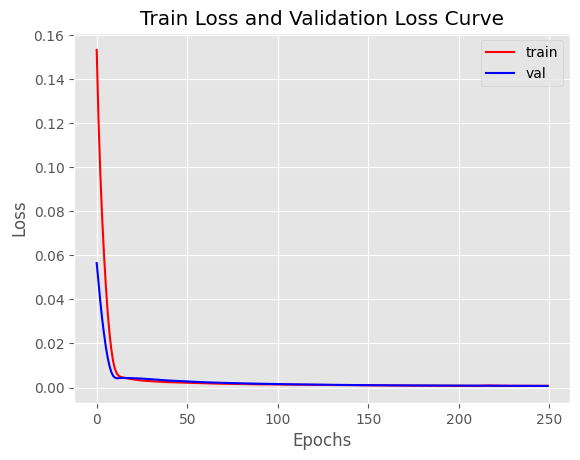

In [29]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [30]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step


In [31]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0010555759111796376
RMSE = 0.032489627747631054
MAPE = 0.046939901762186674
R-Squared Score = 0.8913409440413683


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

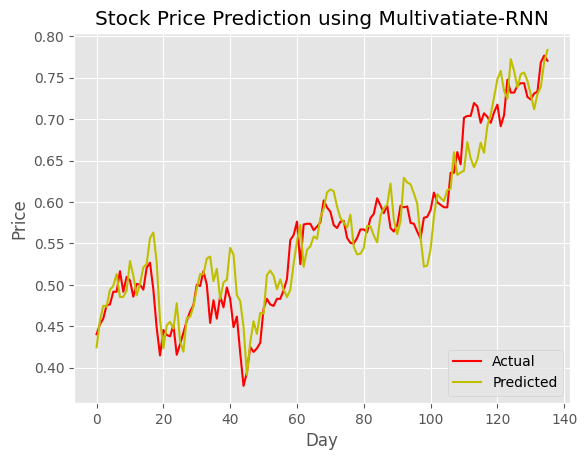

In [32]:
plot_data_2(true, predicted)

In [33]:
# Save a model
model.save('10VAR-szc-rnn.keras')

In [ ]:
del model

# Model 2: Multivariate-3-GRU

## GRU

### Import các thư viện cần thiết

In [34]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [35]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras import optimizers

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [38]:
plt.style.use('ggplot')

### Hàm callback

In [39]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-szc-gru.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"SZC_stock_data.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [41]:
df.head()

,open,high,low,close,volume
time,,,,,
2019-01-15,8.97,8.97,6.58,6.58,109570
2019-01-16,6.58,7.03,6.58,7.03,27940
2019-01-17,7.51,7.51,7.51,7.51,119080
2019-01-18,7.84,7.89,7.51,7.51,50480
2019-01-21,7.51,7.51,7.12,7.12,13560


In [42]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [43]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [44]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.997768
high      0.999022
low       0.998935
close     1.000000
volume    0.444012
Name: close, dtype: float64

In [45]:
print(df.describe().volume) 

count    1.293000e+03
mean     9.618657e+05
std      7.256608e+05
min      2.400000e+02
25%      4.538290e+05
50%      8.436720e+05
75%      1.285800e+06
max      4.346420e+06
Name: volume, dtype: float64


<Axes: >

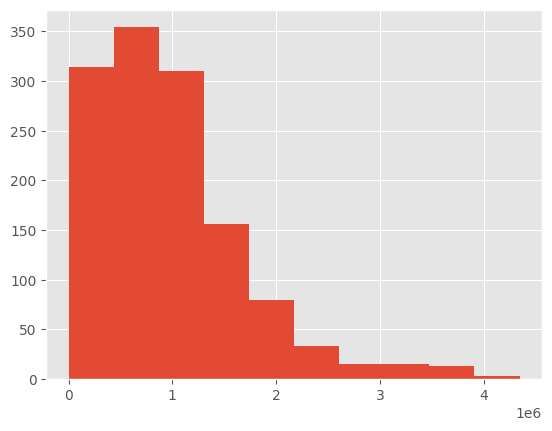

In [46]:
df['volume'].hist(bins= 10)

In [47]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [48]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2019-01-15  8.97  8.97  6.58   6.58  109570    NaN    NaN    NaN  6.580000   
2019-01-16  6.58  7.03  6.58   7.03   27940    NaN    NaN    NaN  6.649231   
2019-01-17  7.51  7.51  7.51   7.51  119080    NaN    NaN    NaN  6.781657   
2019-01-18  7.84  7.89  7.51   7.51   50480    NaN    NaN    NaN  6.893710   
2019-01-21  7.51  7.51  7.12   7.12   13560    NaN    NaN    NaN  6.928524   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2019-01-15  6.580000  0.000000  NaN  NaN NaN NaN  
2019-01-16  6.613333  0.035897  NaN  NaN NaN NaN  
2019-01-17  6.679753  0.101904  NaN  NaN NaN NaN  
2019-01-18  6.741253  0.152457  NaN  NaN NaN NaN  
2019-01-21  6.769308  0.159215  NaN  NaN NaN NaN  


(1293, 15)

## Train model / Hàm **fit_model_3()**

In [49]:
def fit_model_3(train, val, timesteps, hl, lr, batch, epochs):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)
    """
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Thêm các lớp vào mô hình
    model = Sequential()
    model.add(GRU(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i], activation='relu', return_sequences= True))
    model.add(GRU(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện dữ liệu
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)
    
    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, GRU):
            layer.reset_states()
    
    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_3()**

In [50]:
def evaluate_model_3(model, test, timesteps):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    """
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)

    # Các chỉ số đánh giá
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat


## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [51]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-4, 1e-3],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [52]:
# Hàm grid search
def grid_search_rnn(train, val, test, param_grid):
    results = []
    best_score = float('inf')
    best_params = None

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*(param_grid.values())))
    param_names = param_grid.keys()

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f'Training with params: {params}')

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

        # Trả về kết quả
        results_df = pd.DataFrame(results)
        return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [53]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [54]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [55]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(1240, 10)
            close   CMA10   SMA10    SMA50      EMA12        RSI         CCI  \
time                                                                           
2024-03-08  42.01  42.700  42.082  38.1438  41.728648  58.527132   89.439762   
2024-03-11  42.11  42.841  42.214  38.2866  41.787318  61.733333   78.471023   
2024-03-12  43.76  42.695  42.311  38.4576  42.090807  66.471963  151.814600   
2024-03-13  44.15  42.574  42.520  38.6188  42.407606  66.274971  198.091866   
2024-03-14  43.86  42.599  42.700  38.7822  42.631051  74.406332  169.247492   

                   %K         %D      MACD  
time                                        
2024-03-08  57.584270  53.491481  1.160930  
2024-03-11  60.393258  55.799831  1.105357  
2024-03-12  86.560364  68.179298  1.180843  
2024-03-13  85.860656  77.604760  1.257639  
2024-03-14  72.761194  81.727405  1.280341  


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [56]:
series.shape

(1240, 10)

In [57]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(868, 10) (186, 10) (186, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [58]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(868, 10) (186, 10) (186, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [59]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.07570, saving model to 10Var-szc-gru.h5



Epoch 2: val_loss improved from 0.07570 to 0.06414, saving model to 10Var-szc-gru.h5



Epoch 3: val_loss improved from 0.06414 to 0.05369, saving model to 10Var-szc-gru.h5



Epoch 4: val_loss improved from 0.05369 to 0.04205, saving model to 10Var-szc-gru.h5



Epoch 5: val_loss improved from 0.04205 to 0.03081, saving model to 10Var-szc-gru.h5



Epoch 6: val_loss improved from 0.03081 to 0.02139, saving model to 10Var-szc-gru.h5



Epoch 7: val_loss improved from 0.02139 to 0.01375, saving model to 10Var-szc-gru.h5



Epoch 8: val_loss improved from 0.01375 to 0.00786, saving model to 10Var-szc-gru.h5



Epoch 9: val_loss improved from 0.00786 to 0.00381, saving model to 10Var-szc-gru.h5



Epoch 10: val_loss improved from 0.00381 to 0.00160, saving model to 10Var-szc-gru.h5



Epoch 11: val_loss improved from 0.00160 to 0.00102, saving model to 10Var-szc-gru.h5



Epoch 12: val_loss did not improve from 0.00102

Epoch 13: val_loss did not improve from 0.00102

Epoch 14: val_loss did not improve from 0.00102

Epoch 15: val_loss did not improve from 0.00102

Epoch 16: val_loss did not improve from 0.00102

Epoch 17: val_loss did not improve from 0.00102

Epoch 18: val_loss did not improve from 0.00102

Epoch 19: val_loss did not improve from 0.00102

Epoch 20: val_loss did not improve from 0.00102

Epoch 21: val_loss did not improve from 0.00102

Epoch 22: val_loss did not improve from 0.00102

Epoch 23: val_loss did not improve from 0.00102

Epoch 24: val_loss did not improve from 0.00102

Epoch 25: val_loss did not improve from 0.00102

Epoch 26: val_loss did not improve from 0.00102

Epoch 27: val_loss did not improve from 0.00102

Epoch 28: val_loss did not improve from 0.00102

Epoch 29: val_loss did not improve from 0.00102

Epoch 30: val_loss did not improve from 0.00102

Epoch 31: val_loss did not improve from 0.00102

Epoch 32: val_loss 

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022F01A0DB20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
   timesteps        hl      lr  batch_size  num_epochs       mse      rmse  \
0         50  [40, 35]  0.0001          32         200  0.001224  0.034984   

       mape        r2  
0  0.053613  0.874018  
Best parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE score: 0.03498372451419397


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [60]:
timesteps = 30
hl = [40, 35]
lr = 1e-4
batch_size = 32
num_epochs = 200

model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00102

Epoch 2: val_loss did not improve from 0.00102

Epoch 3: val_loss did not improve from 0.00102

Epoch 4: val_loss did not improve from 0.00102

Epoch 5: val_loss did not improve from 0.00102

Epoch 6: val_loss did not improve from 0.00102

Epoch 7: val_loss did not improve from 0.00102

Epoch 8: val_loss improved from 0.00102 to 0.00097, saving model to 10Var-szc-gru.h5



Epoch 9: val_loss did not improve from 0.00097

Epoch 10: val_loss did not improve from 0.00097

Epoch 11: val_loss did not improve from 0.00097

Epoch 12: val_loss did not improve from 0.00097

Epoch 13: val_loss did not improve from 0.00097

Epoch 14: val_loss did not improve from 0.00097

Epoch 15: val_loss did not improve from 0.00097

Epoch 16: val_loss did not improve from 0.00097

Epoch 17: val_loss did not improve from 0.00097

Epoch 18: val_loss did not improve from 0.00097

Epoch 19: val_loss did not improve from 0.00097

Epoch 20: val_loss did not improve from 0.00097

Epoch 21: val_loss did not improve from 0.00097

Epoch 22: val_loss did not improve from 0.00097

Epoch 23: val_loss did not improve from 0.00097

Epoch 24: val_loss did not improve from 0.00097

Epoch 25: val_loss did not improve from 0.00097

Epoch 26: val_loss did not improve from 0.00097

Epoch 27: val_loss did not improve from 0.00097

Epoch 28: val_loss did not improve from 0.00097

Epoch 29: val_loss d


Epoch 52: val_loss improved from 0.00097 to 0.00096, saving model to 10Var-szc-gru.h5



Epoch 53: val_loss improved from 0.00096 to 0.00095, saving model to 10Var-szc-gru.h5



Epoch 54: val_loss improved from 0.00095 to 0.00094, saving model to 10Var-szc-gru.h5



Epoch 55: val_loss improved from 0.00094 to 0.00094, saving model to 10Var-szc-gru.h5



Epoch 56: val_loss improved from 0.00094 to 0.00093, saving model to 10Var-szc-gru.h5



Epoch 57: val_loss improved from 0.00093 to 0.00092, saving model to 10Var-szc-gru.h5



Epoch 58: val_loss improved from 0.00092 to 0.00092, saving model to 10Var-szc-gru.h5



Epoch 59: val_loss improved from 0.00092 to 0.00091, saving model to 10Var-szc-gru.h5



Epoch 60: val_loss improved from 0.00091 to 0.00090, saving model to 10Var-szc-gru.h5



Epoch 61: val_loss improved from 0.00090 to 0.00090, saving model to 10Var-szc-gru.h5



Epoch 62: val_loss improved from 0.00090 to 0.00089, saving model to 10Var-szc-gru.h5



Epoch 63: val_loss improved from 0.00089 to 0.00088, saving model to 10Var-szc-gru.h5



Epoch 64: val_loss improved from 0.00088 to 0.00087, saving model to 10Var-szc-gru.h5



Epoch 65: val_loss improved from 0.00087 to 0.00087, saving model to 10Var-szc-gru.h5



Epoch 66: val_loss improved from 0.00087 to 0.00086, saving model to 10Var-szc-gru.h5



Epoch 67: val_loss improved from 0.00086 to 0.00085, saving model to 10Var-szc-gru.h5



Epoch 68: val_loss improved from 0.00085 to 0.00085, saving model to 10Var-szc-gru.h5



Epoch 69: val_loss improved from 0.00085 to 0.00084, saving model to 10Var-szc-gru.h5



Epoch 70: val_loss improved from 0.00084 to 0.00084, saving model to 10Var-szc-gru.h5



Epoch 71: val_loss improved from 0.00084 to 0.00084, saving model to 10Var-szc-gru.h5



Epoch 72: val_loss improved from 0.00084 to 0.00083, saving model to 10Var-szc-gru.h5



Epoch 73: val_loss improved from 0.00083 to 0.00082, saving model to 10Var-szc-gru.h5



Epoch 74: val_loss improved from 0.00082 to 0.00082, saving model to 10Var-szc-gru.h5



Epoch 75: val_loss improved from 0.00082 to 0.00081, saving model to 10Var-szc-gru.h5



Epoch 76: val_loss improved from 0.00081 to 0.00081, saving model to 10Var-szc-gru.h5



Epoch 77: val_loss improved from 0.00081 to 0.00080, saving model to 10Var-szc-gru.h5



Epoch 78: val_loss improved from 0.00080 to 0.00080, saving model to 10Var-szc-gru.h5



Epoch 79: val_loss improved from 0.00080 to 0.00079, saving model to 10Var-szc-gru.h5



Epoch 80: val_loss improved from 0.00079 to 0.00079, saving model to 10Var-szc-gru.h5



Epoch 81: val_loss improved from 0.00079 to 0.00078, saving model to 10Var-szc-gru.h5



Epoch 82: val_loss improved from 0.00078 to 0.00078, saving model to 10Var-szc-gru.h5



Epoch 83: val_loss improved from 0.00078 to 0.00077, saving model to 10Var-szc-gru.h5



Epoch 84: val_loss improved from 0.00077 to 0.00077, saving model to 10Var-szc-gru.h5



Epoch 85: val_loss improved from 0.00077 to 0.00077, saving model to 10Var-szc-gru.h5



Epoch 86: val_loss improved from 0.00077 to 0.00076, saving model to 10Var-szc-gru.h5



Epoch 87: val_loss improved from 0.00076 to 0.00076, saving model to 10Var-szc-gru.h5



Epoch 88: val_loss improved from 0.00076 to 0.00075, saving model to 10Var-szc-gru.h5



Epoch 89: val_loss improved from 0.00075 to 0.00075, saving model to 10Var-szc-gru.h5



Epoch 90: val_loss improved from 0.00075 to 0.00074, saving model to 10Var-szc-gru.h5



Epoch 91: val_loss improved from 0.00074 to 0.00074, saving model to 10Var-szc-gru.h5



Epoch 92: val_loss improved from 0.00074 to 0.00074, saving model to 10Var-szc-gru.h5



Epoch 93: val_loss improved from 0.00074 to 0.00073, saving model to 10Var-szc-gru.h5



Epoch 94: val_loss improved from 0.00073 to 0.00072, saving model to 10Var-szc-gru.h5



Epoch 95: val_loss improved from 0.00072 to 0.00072, saving model to 10Var-szc-gru.h5



Epoch 96: val_loss improved from 0.00072 to 0.00071, saving model to 10Var-szc-gru.h5



Epoch 97: val_loss improved from 0.00071 to 0.00070, saving model to 10Var-szc-gru.h5



Epoch 98: val_loss improved from 0.00070 to 0.00070, saving model to 10Var-szc-gru.h5



Epoch 99: val_loss improved from 0.00070 to 0.00069, saving model to 10Var-szc-gru.h5



Epoch 100: val_loss improved from 0.00069 to 0.00069, saving model to 10Var-szc-gru.h5



Epoch 101: val_loss improved from 0.00069 to 0.00068, saving model to 10Var-szc-gru.h5



Epoch 102: val_loss improved from 0.00068 to 0.00068, saving model to 10Var-szc-gru.h5



Epoch 103: val_loss improved from 0.00068 to 0.00068, saving model to 10Var-szc-gru.h5



Epoch 104: val_loss improved from 0.00068 to 0.00067, saving model to 10Var-szc-gru.h5



Epoch 105: val_loss improved from 0.00067 to 0.00067, saving model to 10Var-szc-gru.h5



Epoch 106: val_loss improved from 0.00067 to 0.00067, saving model to 10Var-szc-gru.h5



Epoch 107: val_loss improved from 0.00067 to 0.00066, saving model to 10Var-szc-gru.h5



Epoch 108: val_loss improved from 0.00066 to 0.00066, saving model to 10Var-szc-gru.h5



Epoch 109: val_loss improved from 0.00066 to 0.00065, saving model to 10Var-szc-gru.h5



Epoch 110: val_loss improved from 0.00065 to 0.00065, saving model to 10Var-szc-gru.h5



Epoch 111: val_loss improved from 0.00065 to 0.00064, saving model to 10Var-szc-gru.h5



Epoch 112: val_loss improved from 0.00064 to 0.00064, saving model to 10Var-szc-gru.h5



Epoch 113: val_loss improved from 0.00064 to 0.00063, saving model to 10Var-szc-gru.h5



Epoch 114: val_loss improved from 0.00063 to 0.00062, saving model to 10Var-szc-gru.h5



Epoch 115: val_loss improved from 0.00062 to 0.00062, saving model to 10Var-szc-gru.h5



Epoch 116: val_loss improved from 0.00062 to 0.00062, saving model to 10Var-szc-gru.h5



Epoch 117: val_loss improved from 0.00062 to 0.00061, saving model to 10Var-szc-gru.h5



Epoch 118: val_loss improved from 0.00061 to 0.00061, saving model to 10Var-szc-gru.h5



Epoch 119: val_loss improved from 0.00061 to 0.00060, saving model to 10Var-szc-gru.h5



Epoch 120: val_loss improved from 0.00060 to 0.00060, saving model to 10Var-szc-gru.h5



Epoch 121: val_loss improved from 0.00060 to 0.00059, saving model to 10Var-szc-gru.h5



Epoch 122: val_loss improved from 0.00059 to 0.00059, saving model to 10Var-szc-gru.h5



Epoch 123: val_loss improved from 0.00059 to 0.00058, saving model to 10Var-szc-gru.h5



Epoch 124: val_loss improved from 0.00058 to 0.00058, saving model to 10Var-szc-gru.h5



Epoch 125: val_loss improved from 0.00058 to 0.00057, saving model to 10Var-szc-gru.h5



Epoch 126: val_loss improved from 0.00057 to 0.00057, saving model to 10Var-szc-gru.h5



Epoch 127: val_loss improved from 0.00057 to 0.00056, saving model to 10Var-szc-gru.h5



Epoch 128: val_loss improved from 0.00056 to 0.00055, saving model to 10Var-szc-gru.h5



Epoch 129: val_loss improved from 0.00055 to 0.00055, saving model to 10Var-szc-gru.h5



Epoch 130: val_loss improved from 0.00055 to 0.00054, saving model to 10Var-szc-gru.h5



Epoch 131: val_loss improved from 0.00054 to 0.00054, saving model to 10Var-szc-gru.h5



Epoch 132: val_loss improved from 0.00054 to 0.00054, saving model to 10Var-szc-gru.h5



Epoch 133: val_loss improved from 0.00054 to 0.00053, saving model to 10Var-szc-gru.h5



Epoch 134: val_loss improved from 0.00053 to 0.00053, saving model to 10Var-szc-gru.h5



Epoch 135: val_loss improved from 0.00053 to 0.00053, saving model to 10Var-szc-gru.h5



Epoch 136: val_loss improved from 0.00053 to 0.00053, saving model to 10Var-szc-gru.h5



Epoch 137: val_loss improved from 0.00053 to 0.00052, saving model to 10Var-szc-gru.h5



Epoch 138: val_loss improved from 0.00052 to 0.00052, saving model to 10Var-szc-gru.h5



Epoch 139: val_loss improved from 0.00052 to 0.00052, saving model to 10Var-szc-gru.h5



Epoch 140: val_loss improved from 0.00052 to 0.00052, saving model to 10Var-szc-gru.h5



Epoch 141: val_loss improved from 0.00052 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 142: val_loss improved from 0.00051 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 143: val_loss improved from 0.00051 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 144: val_loss improved from 0.00051 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 145: val_loss improved from 0.00051 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 146: val_loss improved from 0.00051 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 147: val_loss did not improve from 0.00051

Epoch 148: val_loss did not improve from 0.00051

Epoch 149: val_loss did not improve from 0.00051

Epoch 150: val_loss did not improve from 0.00051

Epoch 151: val_loss improved from 0.00051 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 152: val_loss improved from 0.00051 to 0.00051, saving model to 10Var-szc-gru.h5



Epoch 153: val_loss improved from 0.00051 to 0.00050, saving model to 10Var-szc-gru.h5



Epoch 154: val_loss improved from 0.00050 to 0.00050, saving model to 10Var-szc-gru.h5



Epoch 155: val_loss improved from 0.00050 to 0.00050, saving model to 10Var-szc-gru.h5



Epoch 156: val_loss improved from 0.00050 to 0.00050, saving model to 10Var-szc-gru.h5



Epoch 157: val_loss did not improve from 0.00050

Epoch 158: val_loss did not improve from 0.00050

Epoch 159: val_loss did not improve from 0.00050

Epoch 160: val_loss did not improve from 0.00050

Epoch 161: val_loss did not improve from 0.00050

Epoch 162: val_loss did not improve from 0.00050

Epoch 163: val_loss did not improve from 0.00050

Epoch 164: val_loss did not improve from 0.00050

Epoch 165: val_loss did not improve from 0.00050

Epoch 166: val_loss did not improve from 0.00050

Epoch 167: val_loss did not improve from 0.00050

Epoch 168: val_loss did not improve from 0.00050

Epoch 169: val_loss did not improve from 0.00050

Epoch 170: val_loss did not improve from 0.00050

Epoch 171: val_loss did not improve from 0.00050

Epoch 172: val_loss did not improve from 0.00050

Epoch 173: val_loss did not improve from 0.00050

Epoch 174: val_loss did not improve from 0.00050

Epoch 175: val_loss did not improve from 0.00050

Epoch 176: val_loss did not improve from 0.00050



Epoch 185: val_loss improved from 0.00048 to 0.00044, saving model to 10Var-szc-gru.h5



Epoch 186: val_loss did not improve from 0.00044

Epoch 187: val_loss did not improve from 0.00044

Epoch 188: val_loss did not improve from 0.00044

Epoch 189: val_loss did not improve from 0.00044

Epoch 190: val_loss did not improve from 0.00044

Epoch 191: val_loss did not improve from 0.00044

Epoch 192: val_loss did not improve from 0.00044

Epoch 193: val_loss did not improve from 0.00044

Epoch 194: val_loss improved from 0.00044 to 0.00042, saving model to 10Var-szc-gru.h5



Epoch 195: val_loss did not improve from 0.00042

Epoch 196: val_loss did not improve from 0.00042

Epoch 197: val_loss did not improve from 0.00042

Epoch 198: val_loss did not improve from 0.00042

Epoch 199: val_loss did not improve from 0.00042

Epoch 200: val_loss did not improve from 0.00042


### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

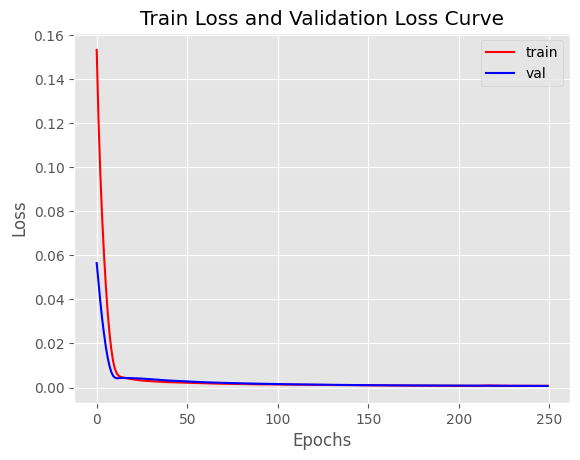

In [61]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [62]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step


In [63]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0008193828573460445
RMSE = 0.02862486432013337
MAPE = 0.04159674168447461
R-Squared Score = 0.9156396651261202


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

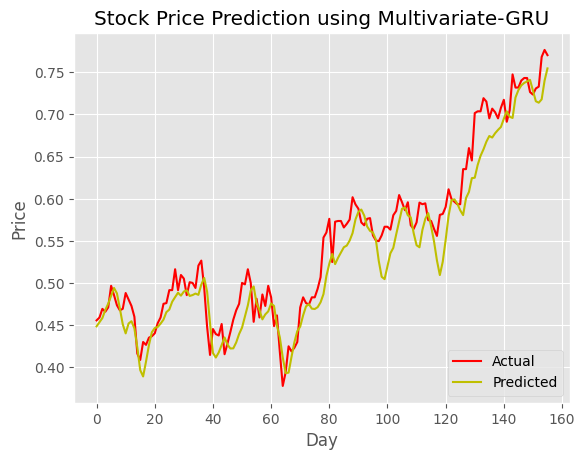

In [64]:
plot_data_3(true, predicted)

In [65]:
# Save a model
model.save('10VAR-szc-gru.keras')

In [206]:
del model

# Model 3: Multivariate-3-LSTM

## LSTM

### Import các thư viện cần thiết

In [66]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [67]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

In [70]:
plt.style.use('ggplot')

### Hàm callback

In [71]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var_szc_lstm.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"SZC_stock_data.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [73]:
df.head()

,open,high,low,close,volume
time,,,,,
2019-01-15,8.97,8.97,6.58,6.58,109570
2019-01-16,6.58,7.03,6.58,7.03,27940
2019-01-17,7.51,7.51,7.51,7.51,119080
2019-01-18,7.84,7.89,7.51,7.51,50480
2019-01-21,7.51,7.51,7.12,7.12,13560


In [74]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [75]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [76]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.997768
high      0.999022
low       0.998935
close     1.000000
volume    0.444012
Name: close, dtype: float64

count    1.293000e+03
mean     9.618657e+05
std      7.256608e+05
min      2.400000e+02
25%      4.538290e+05
50%      8.436720e+05
75%      1.285800e+06
max      4.346420e+06
Name: volume, dtype: float64


<Axes: >

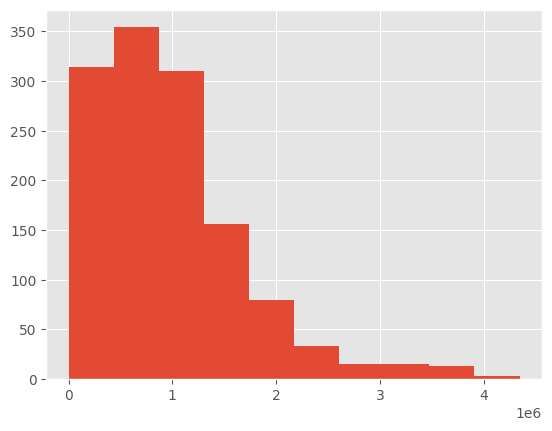

In [77]:
print(df.describe().volume) 
df['volume'].hist(bins= 10)

In [78]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [79]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2019-01-15  8.97  8.97  6.58   6.58  109570    NaN    NaN    NaN  6.580000   
2019-01-16  6.58  7.03  6.58   7.03   27940    NaN    NaN    NaN  6.649231   
2019-01-17  7.51  7.51  7.51   7.51  119080    NaN    NaN    NaN  6.781657   
2019-01-18  7.84  7.89  7.51   7.51   50480    NaN    NaN    NaN  6.893710   
2019-01-21  7.51  7.51  7.12   7.12   13560    NaN    NaN    NaN  6.928524   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2019-01-15  6.580000  0.000000  NaN  NaN NaN NaN  
2019-01-16  6.613333  0.035897  NaN  NaN NaN NaN  
2019-01-17  6.679753  0.101904  NaN  NaN NaN NaN  
2019-01-18  6.741253  0.152457  NaN  NaN NaN NaN  
2019-01-21  6.769308  0.159215  NaN  NaN NaN NaN  


(1293, 15)

## Train model / Hàm **fit_model_4()**

In [80]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation='relu', return_sequences= True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, batch_size= batch, epochs= epochs, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)

    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_state()

    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_4()**

In [81]:
def evaluate_model_4(model, test, timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Các chỉ số
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [82]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [83]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [84]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [85]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [86]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()

(1240, 10)


,close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000
mean,23.922185,23.907293,23.800945,23.281065,23.774227,53.859959,23.864276,55.347558,55.334764,0.182251
std,11.051640,10.997325,10.974661,10.724423,10.929829,17.645922,109.921258,30.334386,28.409879,0.985588
min,7.790000,8.319000,8.319000,7.664600,8.479359,2.400000,-314.348887,0.000000,0.000000,-4.034671
25%,14.197500,14.148500,13.839000,13.238450,13.736157,41.205512,-62.423004,28.300176,28.838193,-0.209920
50%,23.055000,22.756500,22.627000,22.829700,22.904042,54.691071,45.642973,60.917367,60.525771,0.306842
75%,31.242500,31.126500,31.060750,31.221150,30.902806,67.240614,108.659315,82.298464,81.481269,0.714092
max,54.610000,53.114000,53.114000,50.160200,52.765743,92.916667,267.139480,100.000000,99.425287,2.254717


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [87]:
series.shape

(1240, 10)

In [88]:

n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)


(868, 10) (186, 10) (186, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [89]:
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(868, 10) (186, 10) (186, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [90]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.01689, saving model to 10Var_szc_lstm.h5



Epoch 2: val_loss improved from 0.01689 to 0.00142, saving model to 10Var_szc_lstm.h5



Epoch 3: val_loss did not improve from 0.00142

Epoch 4: val_loss did not improve from 0.00142

Epoch 5: val_loss did not improve from 0.00142

Epoch 6: val_loss did not improve from 0.00142

Epoch 7: val_loss did not improve from 0.00142

Epoch 8: val_loss did not improve from 0.00142

Epoch 9: val_loss did not improve from 0.00142

Epoch 10: val_loss did not improve from 0.00142

Epoch 11: val_loss did not improve from 0.00142

Epoch 12: val_loss did not improve from 0.00142

Epoch 13: val_loss did not improve from 0.00142

Epoch 14: val_loss did not improve from 0.00142

Epoch 15: val_loss did not improve from 0.00142

Epoch 16: val_loss did not improve from 0.00142

Epoch 17: val_loss did not improve from 0.00142

Epoch 18: val_loss did not improve from 0.00142

Epoch 19: val_loss did not improve from 0.00142

Epoch 20: val_loss did not improve from 0.00142

Epoch 21: val_loss did not improve from 0.00142

Epoch 22: val_loss did not improve from 0.00142

Epoch 23: val_loss did not


Epoch 54: val_loss improved from 0.00117 to 0.00098, saving model to 10Var_szc_lstm.h5



Epoch 55: val_loss improved from 0.00098 to 0.00087, saving model to 10Var_szc_lstm.h5



Epoch 56: val_loss did not improve from 0.00087

Epoch 57: val_loss did not improve from 0.00087

Epoch 58: val_loss did not improve from 0.00087

Epoch 59: val_loss did not improve from 0.00087

Epoch 60: val_loss did not improve from 0.00087

Epoch 61: val_loss did not improve from 0.00087

Epoch 62: val_loss did not improve from 0.00087

Epoch 63: val_loss did not improve from 0.00087

Epoch 64: val_loss did not improve from 0.00087

Epoch 65: val_loss did not improve from 0.00087

Epoch 66: val_loss did not improve from 0.00087

Epoch 67: val_loss did not improve from 0.00087

Epoch 68: val_loss improved from 0.00087 to 0.00087, saving model to 10Var_szc_lstm.h5



Epoch 69: val_loss improved from 0.00087 to 0.00085, saving model to 10Var_szc_lstm.h5



Epoch 70: val_loss improved from 0.00085 to 0.00082, saving model to 10Var_szc_lstm.h5



Epoch 71: val_loss did not improve from 0.00082

Epoch 72: val_loss did not improve from 0.00082

Epoch 73: val_loss did not improve from 0.00082

Epoch 74: val_loss did not improve from 0.00082

Epoch 75: val_loss did not improve from 0.00082

Epoch 76: val_loss did not improve from 0.00082

Epoch 77: val_loss did not improve from 0.00082

Epoch 78: val_loss did not improve from 0.00082

Epoch 79: val_loss did not improve from 0.00082

Epoch 80: val_loss did not improve from 0.00082

Epoch 81: val_loss did not improve from 0.00082

Epoch 82: val_loss did not improve from 0.00082

Epoch 83: val_loss did not improve from 0.00082

Epoch 84: val_loss did not improve from 0.00082

Epoch 85: val_loss did not improve from 0.00082

Epoch 86: val_loss did not improve from 0.00082

Epoch 87: val_loss did not improve from 0.00082

Epoch 88: val_loss did not improve from 0.00082

Epoch 89: val_loss did not improve from 0.00082

Epoch 90: val_loss improved from 0.00082 to 0.00080, saving model to


Epoch 91: val_loss did not improve from 0.00080

Epoch 92: val_loss improved from 0.00080 to 0.00077, saving model to 10Var_szc_lstm.h5



Epoch 93: val_loss did not improve from 0.00077

Epoch 94: val_loss did not improve from 0.00077

Epoch 95: val_loss did not improve from 0.00077

Epoch 96: val_loss did not improve from 0.00077

Epoch 97: val_loss did not improve from 0.00077

Epoch 98: val_loss did not improve from 0.00077

Epoch 99: val_loss improved from 0.00077 to 0.00075, saving model to 10Var_szc_lstm.h5



Epoch 100: val_loss did not improve from 0.00075

Epoch 101: val_loss did not improve from 0.00075

Epoch 102: val_loss did not improve from 0.00075

Epoch 103: val_loss improved from 0.00075 to 0.00070, saving model to 10Var_szc_lstm.h5



Epoch 104: val_loss did not improve from 0.00070

Epoch 105: val_loss did not improve from 0.00070

Epoch 106: val_loss did not improve from 0.00070

Epoch 107: val_loss did not improve from 0.00070

Epoch 108: val_loss did not improve from 0.00070

Epoch 109: val_loss did not improve from 0.00070

Epoch 110: val_loss did not improve from 0.00070

Epoch 111: val_loss did not improve from 0.00070

Epoch 112: val_loss did not improve from 0.00070

Epoch 113: val_loss did not improve from 0.00070

Epoch 114: val_loss did not improve from 0.00070

Epoch 115: val_loss did not improve from 0.00070

Epoch 116: val_loss did not improve from 0.00070

Epoch 117: val_loss did not improve from 0.00070

Epoch 118: val_loss did not improve from 0.00070

Epoch 119: val_loss did not improve from 0.00070

Epoch 120: val_loss did not improve from 0.00070

Epoch 121: val_loss did not improve from 0.00070

Epoch 122: val_loss did not improve from 0.00070

Epoch 123: val_loss did not improve from 0.00070



Epoch 141: val_loss did not improve from 0.00070

Epoch 142: val_loss improved from 0.00070 to 0.00067, saving model to 10Var_szc_lstm.h5



Epoch 143: val_loss did not improve from 0.00067

Epoch 144: val_loss improved from 0.00067 to 0.00066, saving model to 10Var_szc_lstm.h5



Epoch 145: val_loss improved from 0.00066 to 0.00064, saving model to 10Var_szc_lstm.h5



Epoch 146: val_loss did not improve from 0.00064

Epoch 147: val_loss did not improve from 0.00064

Epoch 148: val_loss did not improve from 0.00064

Epoch 149: val_loss did not improve from 0.00064

Epoch 150: val_loss did not improve from 0.00064

Epoch 151: val_loss improved from 0.00064 to 0.00063, saving model to 10Var_szc_lstm.h5



Epoch 152: val_loss did not improve from 0.00063

Epoch 153: val_loss did not improve from 0.00063

Epoch 154: val_loss did not improve from 0.00063

Epoch 155: val_loss did not improve from 0.00063

Epoch 156: val_loss did not improve from 0.00063

Epoch 157: val_loss did not improve from 0.00063

Epoch 158: val_loss did not improve from 0.00063

Epoch 159: val_loss did not improve from 0.00063

Epoch 160: val_loss did not improve from 0.00063

Epoch 161: val_loss did not improve from 0.00063

Epoch 162: val_loss did not improve from 0.00063

Epoch 163: val_loss did not improve from 0.00063

Epoch 164: val_loss did not improve from 0.00063

Epoch 165: val_loss did not improve from 0.00063

Epoch 166: val_loss did not improve from 0.00063

Epoch 167: val_loss did not improve from 0.00063

Epoch 168: val_loss did not improve from 0.00063

Epoch 169: val_loss did not improve from 0.00063

Epoch 170: val_loss did not improve from 0.00063

Epoch 171: val_loss did not improve from 0.00063



Epoch 190: val_loss did not improve from 0.00063

Epoch 191: val_loss did not improve from 0.00063

Epoch 192: val_loss did not improve from 0.00063

Epoch 193: val_loss did not improve from 0.00063

Epoch 194: val_loss did not improve from 0.00063

Epoch 195: val_loss did not improve from 0.00063

Epoch 196: val_loss did not improve from 0.00063

Epoch 197: val_loss did not improve from 0.00063

Epoch 198: val_loss did not improve from 0.00063

Epoch 199: val_loss did not improve from 0.00063

Epoch 200: val_loss did not improve from 0.00063
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00063

Epoch 2: val_loss did not improve from 0.00063

Epoch 3: val_loss did not improve from 0.00063

Epoch 4: val_loss did not improve from 0.00063

Epoch 5: val_loss did not improve from 0.00063

Epoch 6: val_loss did not improve from 0.00063

Epoch 7: val_loss did not improve from 0.00063

Epoch 8: val_loss did not improve from 0.00063

Epoch 9: val_loss did not improve from 0.00063

Epoch 10: val_loss did not improve from 0.00063

Epoch 11: val_loss did not improve from 0.00063

Epoch 12: val_loss did not improve from 0.00063

Epoch 13: val_loss did not improve from 0.00063

Epoch 14: val_loss did not improve from 0.00063

Epoch 15: val_loss did not improve from 0.00063

Epoch 16: val_loss did not improve from 0.00063

Epoch 17: val_loss did not improve from 0.00063

Epoch 18: val_loss did not improve from 0.00063

Epoch 19: val_loss did not improve from 0.00063

Epoch 20: val_loss did not improve from 0.00063

Epoch 21: val_loss did not i


Epoch 99: val_loss improved from 0.00059 to 0.00058, saving model to 10Var_szc_lstm.h5



Epoch 100: val_loss did not improve from 0.00058

Epoch 101: val_loss did not improve from 0.00058

Epoch 102: val_loss did not improve from 0.00058

Epoch 103: val_loss did not improve from 0.00058

Epoch 104: val_loss did not improve from 0.00058

Epoch 105: val_loss did not improve from 0.00058

Epoch 106: val_loss did not improve from 0.00058

Epoch 107: val_loss did not improve from 0.00058

Epoch 108: val_loss did not improve from 0.00058

Epoch 109: val_loss did not improve from 0.00058

Epoch 110: val_loss did not improve from 0.00058

Epoch 111: val_loss improved from 0.00058 to 0.00056, saving model to 10Var_szc_lstm.h5



Epoch 112: val_loss did not improve from 0.00056

Epoch 113: val_loss did not improve from 0.00056

Epoch 114: val_loss did not improve from 0.00056

Epoch 115: val_loss did not improve from 0.00056

Epoch 116: val_loss did not improve from 0.00056

Epoch 117: val_loss did not improve from 0.00056

Epoch 118: val_loss did not improve from 0.00056

Epoch 119: val_loss did not improve from 0.00056

Epoch 120: val_loss did not improve from 0.00056

Epoch 121: val_loss did not improve from 0.00056

Epoch 122: val_loss did not improve from 0.00056

Epoch 123: val_loss did not improve from 0.00056

Epoch 124: val_loss did not improve from 0.00056

Epoch 125: val_loss did not improve from 0.00056

Epoch 126: val_loss did not improve from 0.00056

Epoch 127: val_loss did not improve from 0.00056

Epoch 128: val_loss did not improve from 0.00056

Epoch 129: val_loss improved from 0.00056 to 0.00052, saving model to 10Var_szc_lstm.h5



Epoch 130: val_loss did not improve from 0.00052

Epoch 131: val_loss did not improve from 0.00052

Epoch 132: val_loss did not improve from 0.00052

Epoch 133: val_loss did not improve from 0.00052

Epoch 134: val_loss did not improve from 0.00052

Epoch 135: val_loss did not improve from 0.00052

Epoch 136: val_loss did not improve from 0.00052

Epoch 137: val_loss did not improve from 0.00052

Epoch 138: val_loss did not improve from 0.00052

Epoch 139: val_loss did not improve from 0.00052

Epoch 140: val_loss did not improve from 0.00052

Epoch 141: val_loss did not improve from 0.00052

Epoch 142: val_loss did not improve from 0.00052

Epoch 143: val_loss did not improve from 0.00052

Epoch 144: val_loss did not improve from 0.00052

Epoch 145: val_loss did not improve from 0.00052

Epoch 146: val_loss did not improve from 0.00052

Epoch 147: val_loss did not improve from 0.00052

Epoch 148: val_loss improved from 0.00052 to 0.00047, saving model to 10Var_szc_lstm.h5



Epoch 149: val_loss did not improve from 0.00047

Epoch 150: val_loss did not improve from 0.00047

Epoch 151: val_loss did not improve from 0.00047

Epoch 152: val_loss did not improve from 0.00047

Epoch 153: val_loss did not improve from 0.00047

Epoch 154: val_loss did not improve from 0.00047

Epoch 155: val_loss did not improve from 0.00047

Epoch 156: val_loss did not improve from 0.00047

Epoch 157: val_loss did not improve from 0.00047

Epoch 158: val_loss did not improve from 0.00047

Epoch 159: val_loss did not improve from 0.00047

Epoch 160: val_loss did not improve from 0.00047

Epoch 161: val_loss did not improve from 0.00047

Epoch 162: val_loss did not improve from 0.00047

Epoch 163: val_loss did not improve from 0.00047

Epoch 164: val_loss did not improve from 0.00047

Epoch 165: val_loss did not improve from 0.00047

Epoch 166: val_loss did not improve from 0.00047

Epoch 167: val_loss did not improve from 0.00047

Epoch 168: val_loss did not improve from 0.00047



Epoch 202: val_loss did not improve from 0.00039

Epoch 203: val_loss did not improve from 0.00039

Epoch 204: val_loss did not improve from 0.00039

Epoch 205: val_loss did not improve from 0.00039

Epoch 206: val_loss did not improve from 0.00039

Epoch 207: val_loss did not improve from 0.00039

Epoch 208: val_loss did not improve from 0.00039

Epoch 209: val_loss improved from 0.00039 to 0.00034, saving model to 10Var_szc_lstm.h5



Epoch 210: val_loss did not improve from 0.00034

Epoch 211: val_loss did not improve from 0.00034

Epoch 212: val_loss did not improve from 0.00034

Epoch 213: val_loss did not improve from 0.00034

Epoch 214: val_loss did not improve from 0.00034

Epoch 215: val_loss did not improve from 0.00034

Epoch 216: val_loss did not improve from 0.00034

Epoch 217: val_loss did not improve from 0.00034

Epoch 218: val_loss did not improve from 0.00034

Epoch 219: val_loss did not improve from 0.00034

Epoch 220: val_loss did not improve from 0.00034

Epoch 221: val_loss did not improve from 0.00034

Epoch 222: val_loss did not improve from 0.00034

Epoch 223: val_loss did not improve from 0.00034

Epoch 224: val_loss improved from 0.00034 to 0.00032, saving model to 10Var_szc_lstm.h5



Epoch 225: val_loss did not improve from 0.00032

Epoch 226: val_loss did not improve from 0.00032

Epoch 227: val_loss did not improve from 0.00032

Epoch 228: val_loss did not improve from 0.00032

Epoch 229: val_loss did not improve from 0.00032

Epoch 230: val_loss did not improve from 0.00032

Epoch 231: val_loss did not improve from 0.00032

Epoch 232: val_loss did not improve from 0.00032

Epoch 233: val_loss did not improve from 0.00032

Epoch 234: val_loss did not improve from 0.00032

Epoch 235: val_loss did not improve from 0.00032

Epoch 236: val_loss did not improve from 0.00032

Epoch 237: val_loss did not improve from 0.00032

Epoch 238: val_loss improved from 0.00032 to 0.00032, saving model to 10Var_szc_lstm.h5



Epoch 239: val_loss did not improve from 0.00032

Epoch 240: val_loss did not improve from 0.00032

Epoch 241: val_loss did not improve from 0.00032

Epoch 242: val_loss did not improve from 0.00032

Epoch 243: val_loss did not improve from 0.00032

Epoch 244: val_loss did not improve from 0.00032

Epoch 245: val_loss did not improve from 0.00032

Epoch 246: val_loss did not improve from 0.00032

Epoch 247: val_loss did not improve from 0.00032

Epoch 248: val_loss did not improve from 0.00032

Epoch 249: val_loss did not improve from 0.00032

Epoch 250: val_loss did not improve from 0.00032
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00032

Epoch 2: val_loss did not improve from 0.00032

Epoch 3: val_loss did not improve from 0.00032

Epoch 4: val_loss did not improve from 0.00032

Epoch 5: val_loss did not improve from 0.00032

Epoch 6: val_loss did not improve from 0.00032

Epoch 7: val_loss did not improve from 0.00032

Epoch 8: val_loss did not improve from 0.00032

Epoch 9: val_loss did not improve from 0.00032

Epoch 10: val_loss did not improve from 0.00032

Epoch 11: val_loss did not improve from 0.00032

Epoch 12: val_loss did not improve from 0.00032

Epoch 13: val_loss did not improve from 0.00032

Epoch 14: val_loss did not improve from 0.00032

Epoch 15: val_loss did not improve from 0.00032

Epoch 16: val_loss did not improve from 0.00032

Epoch 17: val_loss did not improve from 0.00032

Epoch 18: val_loss did not improve from 0.00032

Epoch 19: val_loss did not improve from 0.00032

Epoch 20: val_loss did not improve from 0.00032

Epoch 21: val_loss did not i


Epoch 180: val_loss did not improve from 0.00031

Epoch 181: val_loss did not improve from 0.00031

Epoch 182: val_loss did not improve from 0.00031

Epoch 183: val_loss did not improve from 0.00031

Epoch 184: val_loss did not improve from 0.00031

Epoch 185: val_loss did not improve from 0.00031

Epoch 186: val_loss did not improve from 0.00031

Epoch 187: val_loss did not improve from 0.00031

Epoch 188: val_loss did not improve from 0.00031

Epoch 189: val_loss did not improve from 0.00031

Epoch 190: val_loss did not improve from 0.00031

Epoch 191: val_loss did not improve from 0.00031

Epoch 192: val_loss did not improve from 0.00031

Epoch 193: val_loss did not improve from 0.00031

Epoch 194: val_loss did not improve from 0.00031

Epoch 195: val_loss did not improve from 0.00031

Epoch 196: val_loss did not improve from 0.00031

Epoch 197: val_loss did not improve from 0.00031

Epoch 198: val_loss did not improve from 0.00031

Epoch 199: val_loss did not improve from 0.00031



Epoch 201: val_loss did not improve from 0.00029

Epoch 202: val_loss did not improve from 0.00029

Epoch 203: val_loss did not improve from 0.00029

Epoch 204: val_loss did not improve from 0.00029

Epoch 205: val_loss did not improve from 0.00029

Epoch 206: val_loss did not improve from 0.00029

Epoch 207: val_loss did not improve from 0.00029

Epoch 208: val_loss did not improve from 0.00029

Epoch 209: val_loss did not improve from 0.00029

Epoch 210: val_loss did not improve from 0.00029

Epoch 211: val_loss did not improve from 0.00029

Epoch 212: val_loss did not improve from 0.00029

Epoch 213: val_loss did not improve from 0.00029

Epoch 214: val_loss did not improve from 0.00029

Epoch 215: val_loss improved from 0.00029 to 0.00026, saving model to 10Var_szc_lstm.h5



Epoch 216: val_loss did not improve from 0.00026

Epoch 217: val_loss did not improve from 0.00026

Epoch 218: val_loss did not improve from 0.00026

Epoch 219: val_loss did not improve from 0.00026

Epoch 220: val_loss did not improve from 0.00026

Epoch 221: val_loss did not improve from 0.00026

Epoch 222: val_loss did not improve from 0.00026

Epoch 223: val_loss did not improve from 0.00026

Epoch 224: val_loss did not improve from 0.00026

Epoch 225: val_loss did not improve from 0.00026

Epoch 226: val_loss did not improve from 0.00026

Epoch 227: val_loss did not improve from 0.00026

Epoch 228: val_loss did not improve from 0.00026

Epoch 229: val_loss did not improve from 0.00026

Epoch 230: val_loss improved from 0.00026 to 0.00025, saving model to 10Var_szc_lstm.h5



Epoch 231: val_loss did not improve from 0.00025

Epoch 232: val_loss did not improve from 0.00025

Epoch 233: val_loss did not improve from 0.00025

Epoch 234: val_loss did not improve from 0.00025

Epoch 235: val_loss did not improve from 0.00025

Epoch 236: val_loss did not improve from 0.00025

Epoch 237: val_loss did not improve from 0.00025

Epoch 238: val_loss did not improve from 0.00025

Epoch 239: val_loss did not improve from 0.00025

Epoch 240: val_loss did not improve from 0.00025

Epoch 241: val_loss did not improve from 0.00025

Epoch 242: val_loss did not improve from 0.00025

Epoch 243: val_loss did not improve from 0.00025

Epoch 244: val_loss did not improve from 0.00025

Epoch 245: val_loss did not improve from 0.00025

Epoch 246: val_loss did not improve from 0.00025

Epoch 247: val_loss did not improve from 0.00025

Epoch 248: val_loss did not improve from 0.00025

Epoch 249: val_loss did not improve from 0.00025

Epoch 250: val_loss did not improve from 0.00025


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [91]:
timesteps = 50
hl = [40, 35]
lr = 1e-3
batch_size = 32
num_epochs = 250

model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00025

Epoch 2: val_loss did not improve from 0.00025

Epoch 3: val_loss did not improve from 0.00025

Epoch 4: val_loss did not improve from 0.00025

Epoch 5: val_loss did not improve from 0.00025

Epoch 6: val_loss did not improve from 0.00025

Epoch 7: val_loss did not improve from 0.00025

Epoch 8: val_loss did not improve from 0.00025

Epoch 9: val_loss did not improve from 0.00025

Epoch 10: val_loss did not improve from 0.00025

Epoch 11: val_loss did not improve from 0.00025

Epoch 12: val_loss did not improve from 0.00025

Epoch 13: val_loss did not improve from 0.00025

Epoch 14: val_loss did not improve from 0.00025

Epoch 15: val_loss did not improve from 0.00025

Epoch 16: val_loss did not improve from 0.00025

Epoch 17: val_loss did not improve from 0.00025

Epoch 18: val_loss did not improve from 0.00025

Epoch 19: val_loss did not improve from 0.00025

Epoch 20: val_loss did not improve from 0.00025

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

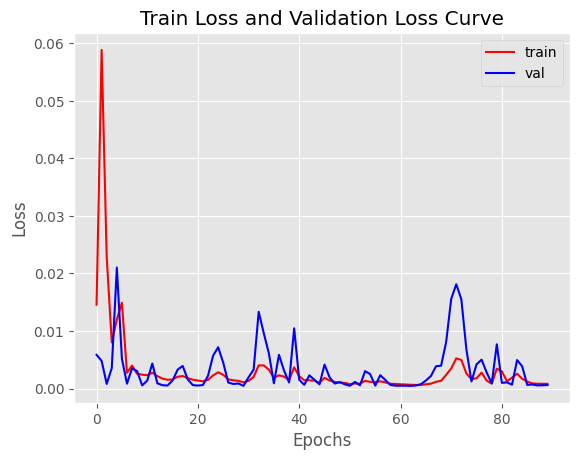

In [92]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [93]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step


In [94]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.000826151321881605
RMSE = 0.028742848186663846
MAPE = 0.04389271305944009
R-Squared Score = 0.9149574921482326


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

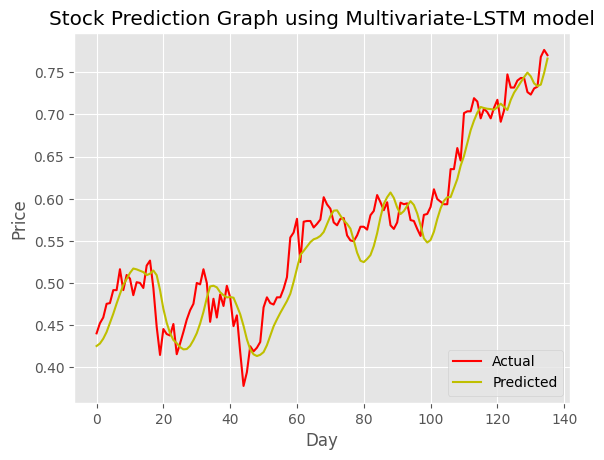

In [95]:
plot_data_4(true, predicted)

In [96]:
# Save a model
model.save('10VAR-szc-lstm.keras')

In [ ]:
del model